In [2]:
import json

import numpy as np
import matplotlib.pyplot as plt

from experiment_utils import EXPERIMENT_PATH


plt.style.use("ggplot")

In [ ]:
experiment_name = "control_sift_hnsw (2025-04-02 21:17:57)"
experiment_dir = EXPERIMENT_PATH / experiment_name
with open(experiment_dir / "results.json", "r") as f:
    experiment_data = json.load(f)

In [4]:
search_times = np.array(experiment_data["search_times"])

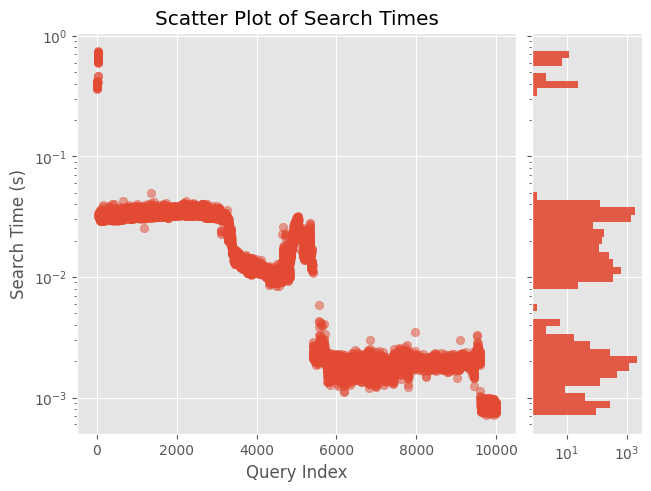

In [7]:
fig, axes = plt.subplot_mosaic(
    [["scatter", "histogram"]],
    layout="constrained",
    width_ratios=[4, 1],
    height_ratios=[1],
)

# Scatter plot
axes["scatter"].scatter(
    np.arange(len(search_times)), search_times, alpha=0.5
)
axes["scatter"].set_title("Scatter Plot of Search Times")
axes["scatter"].set_xlabel("Query Index")
axes["scatter"].set_ylabel("Search Time (s)")
axes["scatter"].set_yscale("log")
axes["histogram"].set_yscale("log")

# Histogram
bins = np.logspace(np.log10(search_times.min()), np.log10(search_times.max()), 50)
axes["histogram"].hist(
    search_times, bins=bins, alpha=0.9, orientation="horizontal"
)
axes["histogram"].set_xscale("log")
axes["histogram"].tick_params(axis="y", labelleft=False)

plt.show()


/tmp/ipykernel_112838/2191587123.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


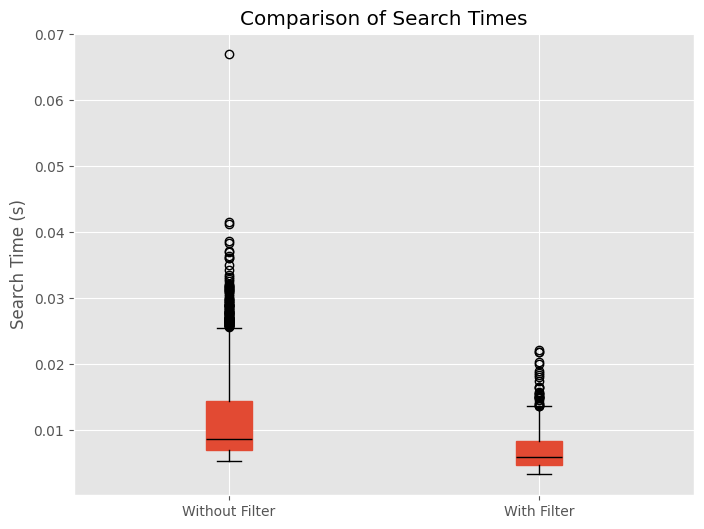

In [40]:
fig, ax = plt.subplots(figsize=(8, 6))

# Separate search times based on filter usage
search_times_with_filter = search_times[filter_used]
search_times_without_filter = search_times[~filter_used]

# Create box plots
ax.boxplot(
    [search_times_without_filter, search_times_with_filter],
    labels=["Without Filter", "With Filter"],
    patch_artist=True,
    boxprops=dict(facecolor=filter_colors[0], color=filter_colors[0]),
    medianprops=dict(color="black"),
)

ax.set_title("Comparison of Search Times")
ax.set_ylabel("Search Time (s)")

plt.show()

/tmp/ipykernel_112838/1679198579.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


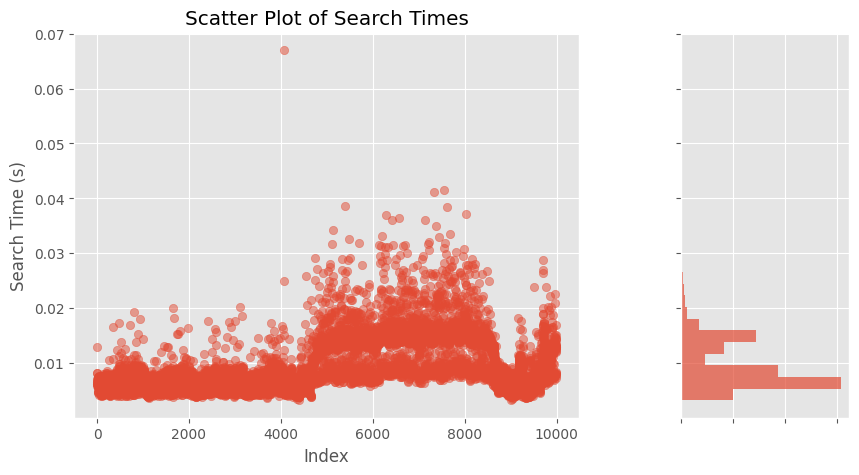

In [ ]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 5))
gs = GridSpec(1, 2, width_ratios=[3, 1], wspace=0.3)

# Scatter plot
ax_scatter = fig.add_subplot(gs[0])
ax_scatter.scatter(range(len(search_times)), search_times, alpha=0.5)
ax_scatter.set_title("Scatter Plot of Search Times")
ax_scatter.set_xlabel("Index")
ax_scatter.set_ylabel("Search Time (s)")

# Histogram
ax_hist = fig.add_subplot(gs[1])
ax_hist.hist(search_times, bins=30, orientation='horizontal', alpha=0.7, density=True)
ax_hist.set_xticklabels([])
ax_hist.set_yticklabels([])

plt.show()